In [1]:
import pandas as pd

<AxesSubplot:>

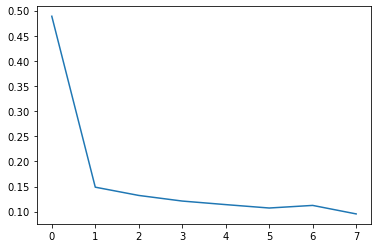

In [8]:
pd.read_pickle('data/results/train_val_metrics_2021-12-31.pkl')['CNN']['train_loss'].plot()

In [10]:
from data_utils import dataloader
import pandas as pd
#from models import BillNet
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
#from import_dataloader_and_class_weights import import_data_loaders_and_class_weights
from data_utils import straitified_train_validation_split, dataloader
from sklearn.utils.class_weight import compute_class_weight

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'straitified_train_validation_split' from 'data_utils' (/home/matiasp/University/deeplearningproject/data_utils.py)

## Prepare Metadata

In [ ]:
codebook = pd.read_csv('data/processed/billscodebook.csv', index_col=0)

In [10]:
metadata = pd.read_csv('data/processed/bill_metadata.csv', index_col=0)

/home/matiasp/miniconda3/envs/pyenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (55,58,59,60,61,62,63,64,65,66,67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
keepcols = ['bill_id', 'status', 'cong', 'Cosponsr', 'Majority', 'Gender', 'Party']

In [12]:
metadata = metadata[keepcols]#.head(50)
metadata[['republican', 'independent']] = pd.get_dummies(metadata['Party'], drop_first=True)

In [13]:
train_meta = metadata.loc[metadata['cong'] != 115][['Cosponsr', 'Majority', 'Gender', 'republican', 'independent']]

In [14]:
train_meta = torch.tensor(train_meta.to_numpy())

In [15]:
train_meta = train_meta.nan_to_num()

In [16]:
torch.save(train_meta, 'data/processed/meta_train_103-114.pt')

In [18]:
test_meta = metadata.loc[metadata['cong'] == 115][['Cosponsr', 'Majority', 'Gender', 'republican', 'independent']]
test_meta = torch.tensor(test_meta.to_numpy())
test_meta = test_meta.nan_to_num()
torch.save(test_meta, 'data/processed/meta_test_115.pt')

In [ ]:
#labels_train = torch.load(path + 'labels_train_103-114.pt')

In [ ]:
(torch.tensor(train_meta['status'].to_numpy()) == labels_train).sum()

In [ ]:
train_meta

## Read in and prepare data

In [5]:
bert_train.shape

torch.Size([16560, 1, 87, 384])

In [9]:
labels_train[labels_train==1].sum()

tensor(716)

In [16]:
path = 'data/processed/'
#Read tensors
bert_train = torch.load(path + 'bert_train_103-114.pt')
meta_train = torch.load(path + 'meta_train_103-114.pt')
labels_train = torch.load(path + 'labels_train_103-114.pt')

#Stratified split into training and validation
splits = straitified_train_validation_split(bert_train,
                                           meta_train, 
                                           labels_train
                                             )

#Calculate class weights for loss function because of unbalance
class_weights=compute_class_weight('balanced', classes = np.unique(labels_train.numpy()),
                                   y = labels_train.numpy())

class_weights=torch.tensor(class_weights,dtype=torch.float)

#Load into training and validation dataloaders
train_dataloader = dataloader(bert_train, labels_train,meta_train, batch_size=16)
valid_dataloader = dataloader(bert_val, labels_val,meta_val, batch_size=16)
#del bert_train, bert_val, labels_train, labels_val

NameError: name 'bert_val' is not defined

## CNN for the N x S x K embeddings

In [ ]:
train_dataloader.dataset.meta

In [8]:
#Define network, optimizer and criterion
net = BillNet(num_classes = 2)
net = net.cuda()

optimizer = optim.Adam(net.parameters(), lr=0.001, 
                       weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
#criterion = nn.CrossEntropyLoss(weight=class_weights)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

print(net)

/home/matiasp/miniconda3/envs/pyenv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


BillNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)


In [2]:
max_epochs = 6
train_acc = []
losses = []
val_recall_scores = []
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    train_preds, train_targs = [], []
    cur_loss = 0.0
    net.train()
    training_loop = tqdm(iter(train_dataloader), leave=True)
    for local_emb, local_labels, local_meta in training_loop:
        # Zero gradient
        optimizer.zero_grad()
        # Transfer to GPU
        local_emb = local_emb.to(device, dtype=torch.float)
        local_meta = local_meta.to(device, dtype=torch.float)
        local_labels = local_labels.to(device, dtype=torch.long)
        # zero the parameter gradients
       
        # Model computations
        output = net(local_emb, local_meta)
        batch_loss = criterion(output, local_labels)
        batch_loss.backward()
        optimizer.step()
        training_loop.set_description(f'Epoch {epoch+1}')
        training_loop.set_postfix(loss=batch_loss.item())
        cur_loss += batch_loss
        # Get predictions
        predicted = torch.max(output, 1)[1]
        train_targs += list(local_labels.cpu().numpy())
        train_preds += list(predicted.data.cpu().numpy())
    
    print('-----------Training Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(train_targs, train_preds)))
    print('F1: {}'.format(f1_score(train_targs, train_preds)))
    print('Precision: {}'.format(precision_score(train_targs, train_preds)))
    print('Recall: {}'.format(recall_score(train_targs, train_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(train_targs, train_preds))

    # Validation
    net.eval()
    val_preds, val_targs = [], []
    probas = []
    with torch.no_grad():
        for local_emb, local_labels, local_meta in valid_dataloader:
            local_emb = local_emb.to(device, dtype=torch.float)
            local_meta = local_meta.to(device, dtype=torch.float)
            local_labels =  local_labels.to(device, dtype=torch.long)
            outputs = net(local_emb, local_meta)
            predicted = torch.max(outputs.data, 1)[1]
            probas += list(outputs.data.cpu().numpy()[:,1])
            val_targs += list(local_labels.cpu().numpy())
            val_preds += list(predicted.data.cpu().numpy())
    
    #lr_fpr, lr_tpr, _ = roc_curve(val_targs, probas)
    print('-----------Validation Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(val_targs, val_preds)))
    print('F1: {}'.format(f1_score(val_targs, val_preds)))
    print('Precision: {}'.format(precision_score(val_targs, val_preds)))
    print('Recall: {}'.format(recall_score(val_targs, val_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(val_targs, val_preds))
    print('-' * 66)

NameError: name 'net' is not defined

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(val_targs, probas)

In [ ]:

with plt.style.context('science'):
    fig, axs = plt.subplots(ncols = 2, dpi = 500, figsize=(8,3))
    ns_probs = [0 for _ in range(len(val_targs))]
    ns_fpr, ns_tpr, _ = roc_curve(val_targs, ns_probs)
    #with plt.style.context('science'):
    axs[0].plot(lr_fpr, lr_tpr, 'ko--', markersize=2, label='Prediction')
    axs[0].plot(ns_fpr, ns_tpr, linestyle='--', label='Random Classifier')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC')
    axs[0].legend()

    axs[1].plot(lr_precision, lr_recall, 'ko--', markersize=2, label='Prediction')
    no_skill = len([t for t in val_targs if t ==1]) / len(val_targs)
    axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Classifier')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precission')
    axs[1].set_title('Precision-Recall')
    axs[1].legend()
plt.tight_layout()
plt.savefig('metrics.pdf', format='pdf')

In [ ]:
from sklearn.metrics import roc_auc_score


In [ ]:
roc_auc_score(train_targs, train_preds)

In [ ]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(val_targs, val_preds)
print(conf_mat)


In [ ]:
#torch.save(net.state_dict(), 'trained_model.obj')
#net = Net(num_classes = 2)
#net.load_state_dict(torch.load('trained_model.obj'))

## FNN

In [33]:
from model import BillNet_FFNN
net = BillNet_FFNN(in_dim = 389, num_classes = 2)
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001, 
                        weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
#criterion = nn.CrossEntropyLoss(weight=class_weights)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

print(net)

BillNet_FFNN(
  (fc1): Linear(in_features=389, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [38]:
max_epochs = 6
train_acc = []
losses = []
val_recall_scores = []
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    train_preds, train_targs = [], []
    cur_loss = 0.0
    net.train()
    training_loop = tqdm(iter(train_dataloader), leave=True)
    for local_emb, local_labels, local_meta in training_loop:
        local_emb = local_emb[~torch.all(local_emb == 0, axis=2)]
        local_emb = torch.mean(local_emb,axis = 2) #take the mean of the sentences in each document (dim 2 (with 0 indexing))
        local_emb = torch.squeeze(local_emb) #remove the channel dim we put there for CNN
        # Zero gradient
        optimizer.zero_grad()
        # Transfer to GPU
        local_emb = local_emb.to(device, dtype=torch.float)
        local_meta = local_meta.to(device, dtype=torch.float)
        local_labels = local_labels.to(device, dtype=torch.long)
        # zero the parameter gradients
       
        # Model computations
        output = net(local_emb, local_meta)
        batch_loss = criterion(output, local_labels)
        batch_loss.backward()
        optimizer.step()
        training_loop.set_description(f'Epoch {epoch+1}')
        training_loop.set_postfix(loss=batch_loss.item())
        cur_loss += batch_loss
        # Get predictions
        predicted = torch.max(output, 1)[1]
        train_targs += list(local_labels.cpu().numpy())
        train_preds += list(predicted.data.cpu().numpy())
    
    print('-----------Training Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(train_targs, train_preds)))
    print('F1: {}'.format(f1_score(train_targs, train_preds)))
    print('Precision: {}'.format(precision_score(train_targs, train_preds)))
    print('Recall: {}'.format(recall_score(train_targs, train_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(train_targs, train_preds))

    # Validation
    net.eval()
    val_preds, val_targs = [], []
    probas = []
    with torch.no_grad():
        for local_emb, local_labels, local_meta in valid_dataloader:
            
            local_emb = torch.mean(local_emb,axis = 2) #take the mean of the sentences in each document (dim 2 (with 0 indexing))
            local_emb = torch.squeeze(local_emb) #remove the channel dim we put there for CNN
            local_emb = local_emb.to(device, dtype=torch.float)
            local_meta = local_meta.to(device, dtype=torch.float)
            local_labels =  local_labels.to(device, dtype=torch.long)
            outputs = net(local_emb, local_meta)
            predicted = torch.max(outputs.data, 1)[1]
            probas += list(outputs.data.cpu().numpy()[:,1])
            val_targs += list(local_labels.cpu().numpy())
            val_preds += list(predicted.data.cpu().numpy())
    
    #lr_fpr, lr_tpr, _ = roc_curve(val_targs, probas)
    print('-----------Validation Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(val_targs, val_preds)))
    print('F1: {}'.format(f1_score(val_targs, val_preds)))
    print('Precision: {}'.format(precision_score(val_targs, val_preds)))
    print('Recall: {}'.format(recall_score(val_targs, val_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(val_targs, val_preds))
    print('-' * 66)



  0%|                                                                                                                                                                | 0/1035 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

## Test data

In [ ]:
#OLD
#import pandas as pd

#test_dataset = np.load('')
#test_dataset = test_dataset[:,None,:, :]
#test_labels = pd.read_pickle('data/processed/test_dat.pkl')
#bill_status = pd.read_csv('data/processed/bill_status.csv').rename({'bill':'bill_id'}, axis=1)
#test_labels = test_labels.merge(bill_status, on = 'bill_id', how='left')['status'].to_numpy()

In [22]:
test_dataset = torch.load('data/processed/bert_test_115.pt')
test_labels = torch.load('data/processed/labels_test_115.pt')
test_meta = torch.load('data/processed/meta_test_115.pt')

In [23]:
test_dataloader = dataloader(test_dataset, test_meta, test_labels, batch_size=64)

In [28]:
state = torch.load('trained_models/CNN inc. meta-epoch=02-val_loss=0.13.ckpt')

In [29]:
from models_lightning import BillNet_CNN

In [32]:
net = BillNet_CNN()

/home/matiasp/miniconda3/envs/pyenv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
from models import BillNet_CNN, BillNet_FNN

In [15]:
my_model = BillNet_CNN()
chk_path = "trained_models/CNN-epoch=08-val_loss=0.13.ckpt"
net = my_model.load_from_checkpoint(chk_path, strict=False)
net.summarize()

   | Name       | Type             | Params
-------------------------------------------------
0  | criterion  | CrossEntropyLoss | 0     
1  | conv1      | Conv2d           | 640   
2  | batchnorm1 | BatchNorm2d      | 128   
3  | conv2      | Conv2d           | 18.5 K
4  | batchnorm2 | BatchNorm2d      | 64    
5  | conv3      | Conv2d           | 4.6 K 
6  | pool       | MaxPool2d        | 0     
7  | dropout2d  | Dropout2d        | 0     
8  | dropout    | Dropout          | 0     
9  | fc1        | LazyLinear       | 795 K 
10 | fc2        | Linear           | 242   
-------------------------------------------------
819 K     Trainable params
0         Non-trainable params
819 K     Total params
3.277     Total estimated model params size (MB)

In [16]:
from data_utils import BillNetDataModule

In [26]:
pd.read_pickle('data/processed/bert_data.pickle')

,bill_id,sentences,status,cong
0,103_hr1002,"[This Act may be cited as the ""Public Housing ...",0,103
1,103_hr1003,"[This Act may be cited as the ""Targeted Econom...",0,103
2,103_hr1005,[The Administrator shall conduct a study of St...,0,103
3,103_hr1007,[Medicaid Benefits Continued for 36 Months for...,0,103
4,103_hr1013,"[This Act may be cited as the ""Expedited Consi...",0,103
...,...,...,...,...
22110,115_s875,"[In this section the term ""Administrative Proc...",0,115
22111,115_s878,[Section 222 of the Communications Act of 1934...,0,115
22112,115_s914,"[This Act may be cited as the ""Safe Drinking W...",0,115
22113,115_s960,"[This Act may be cited as the ""Preserving Data...",0,115


In [19]:
dm = BillNetDataModule()
dm.setup()

target train 0/1: 15987/573
class weights: [ 0.51792081 14.45026178]


In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

net.eval()
test_preds, test_targs = [], []
with torch.no_grad():
    for local_batch, local_meta, local_labels in dm.test_dataloader():
        #local_batch = local_batch.to(device, dtype=torch.float)
        #local_labels =  local_labels.to(device, dtype=torch.long)
        outputs = net(local_batch.float())
        predicted = torch.max(outputs.data, 1)[1]
        test_targs += list(local_labels.cpu().numpy())
        test_preds += list(predicted.data.cpu().numpy())
print('-----------Test Metrics-----------')
print('Accuracy: {}'.format(accuracy_score(test_targs, test_preds)))
print('F1: {}'.format(f1_score(test_targs, test_preds)))
print('Precision: {}'.format(precision_score(test_targs, test_preds)))
print('Recall: {}'.format(recall_score(test_targs, test_preds)))
print('ROCAUC: {}'.format(roc_auc_score(test_targs, test_preds)))
print('PRAUC: {}'.format(average_precision_score(test_targs, test_preds)))
print(confusion_matrix(test_targs, test_preds))

-----------Test Metrics-----------
Accuracy: 0.9893917963224894
F1: 0.845360824742268
Precision: 0.9534883720930233
Recall: 0.7592592592592593
ROCAUC: 0.8788943355119826


NameError: name 'average_precision_score' is not defined

In [ ]:
roc_auc_score(test_targs, test_preds)